## 00. Pacotes

In [ ]:
import pandas as pd
import numpy as np
import random
import gc

import matplotlib.pyplot as plt
import itertools

# Filter out the ConvergenceWarning
from sklearn.exceptions import ConvergenceWarning

from datetime import date, datetime
from tqdm import tqdm

# Definindo a semente
random.seed(123)

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Modelo de Concessão de Crédito

**Objetivo** - Desenvolvimento um modelo de Concessão de Crédito (Application) para população com pouca informação de crédito, que tenha a capacidade de gerar um score de risco para a contratação de produtos de crédito.

**Métodos de avaliação** - Métricas: AUC, KS e Gini

# Entendimento dos dados

**Application Train** - Base de público para treino

**Application Test** - Base de público para escoragem

**Bureau** - Dados de outras instituições financeiras

**Bureau Balance** - Informações mensais sobre créditos anteriores do cliente em outras infituições financeiras

# Mapa dos dados

- Mapa mostrando o relacionamento entre as tabelas, assim como as chaves secundária (SK_ID_BUREAU) e primária (SK_ID_CURR).

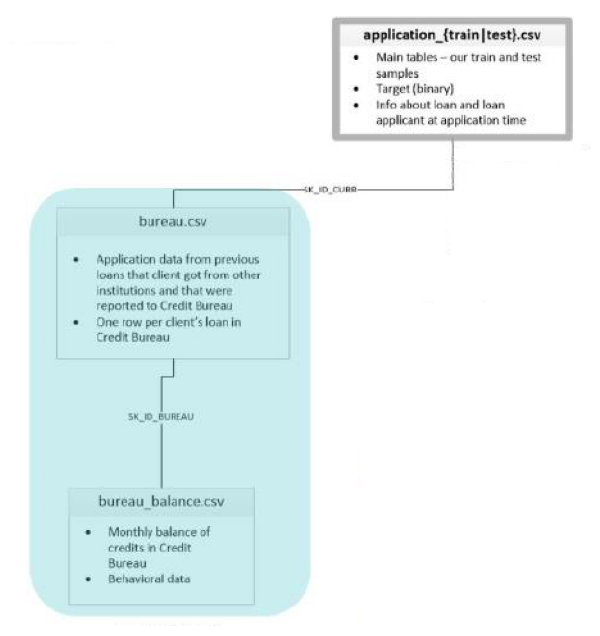

In [ ]:
caminho_imagem = '/content/gdrive/MyDrive/01_Case_Credito/dados_modelagem_proj_credito.png'
img = mpimg.imread(caminho_imagem)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

## Tabela Application Train de modelagem
 - Após considerar os filtros duros

In [ ]:
# Tabela Application Train

df_app_train = pd.read_parquet('/content/gdrive/MyDrive/dados/bases_finais/base_treino_final_modelagem.parquet')
df_app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50
0,247330,0,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,...,0.8247617098091082,0.333515951081393,0.2932598195076287,0.5648777101547645,0.11505831772037989,0.6556052276358179,0.41556216040539806,0.09264289217164834,0.7233310073651865,0.7965229597223112
1,425716,1,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,...,0.4162601539550145,0.4042931976496069,0.1379443228288888,0.457971154221785,0.3036911087667592,0.21505926326838098,0.8388923591826062,0.6083350684761425,0.5856425994040045,0.2984564024497547
2,331625,0,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,...,0.03771070797182219,0.12446471602448061,0.0918395888589979,0.36460055729608953,0.9782197746384983,0.5203089189277581,0.594522775942415,0.5596504605548295,0.3618727890818375,0.25480416707693077
3,455397,0,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,...,0.7846304216904584,0.8314028605097469,0.21087150815897793,0.04963913221128613,0.8142191403975102,0.8301787965200871,0.7551626329455876,0.21666399439235384,0.6030019784645395,0.429000625961821
4,449114,0,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,...,0.2653810525253658,0.6553439524690605,0.6687052951863605,0.17139136654190013,0.33570223528628784,0.5854939663015881,0.6195511068142575,0.6867378529592892,0.5404492330866939,0.34363209601595046


In [ ]:
# Dimensões do público
df_app_train.shape

(184350, 172)

In [ ]:
# 1- Tratando as variáveis

# Função que otimiza os tipos das variáveis classificando-as do modo mais adequado

def otimiza_tipos(df):
    for col in df.columns:
        # Forçar conversão de colunas tipo 'object' para número, se possível
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_numeric(df[col])
            except:
                pass  # Mantém como objeto se não for possível converter

        if pd.api.types.is_integer_dtype(df[col]):
            if df[col].max() > np.iinfo(np.int32).max or df[col].min() < np.iinfo(np.int32).min:
                df[col] = df[col].astype('Int64')
            else:
                df[col] = df[col].astype('Int32')

        elif pd.api.types.is_float_dtype(df[col]):
            if df[col].max() > np.finfo(np.float32).max or df[col].min() < -np.finfo(np.float32).max:
                df[col] = df[col].astype('float64')  # Evita usar 'Float64' Pandas
            else:
                df[col] = df[col].astype('float32')

    return df

df_dados = otimiza_tipos(df_app_train)
print('Variáveis otimizadas!')

Variáveis otimizadas!


In [ ]:
vars = df_app_train.columns[2:].tolist()

lista_vars_num = []
lista_vars_categ = []
lista_vars_erro = []

for var in vars:
    tipo_coluna = df_app_train[var].dtype
    if tipo_coluna.name in (['Int32', 'Int64', 'int32', 'int64', 'Float32', 'Float64', 'float32', 'float64']):
        lista_vars_num.append(var)
    elif tipo_coluna.name in (['object', 'string', 'category']):
        lista_vars_categ.append(var)
    else:
        lista_vars_erro.append(var)

print(f'lista_vars_num: {len(lista_vars_num)}')
print()
print(f'lista_vars_categ: {len(lista_vars_categ)}')
print()
print(f'lista_vars_erro: {len(lista_vars_erro)}')


lista_vars_num: 154

lista_vars_categ: 16

lista_vars_erro: 0


In [ ]:
df_app_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184350 entries, 0 to 184349
Data columns (total 172 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    Int32  
 1    TARGET                        Int32  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  Int32  
 7    AMT_INCOME_TOTAL              float32
 8    AMT_CREDIT                    float32
 9    AMT_ANNUITY                   float32
 10   AMT_GOODS_PRICE               float32
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float32
 17   DAYS_BIRTH                    Int32  
 18   DA

In [ ]:
# Colocando as variáveis em ordem alfabética
lista_appl = sorted(list(df_app_train.columns))
lista_appl

['AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'CODE_GENDER',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'EMERGENCYSTATE_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT

In [ ]:
# Lista de variáveis numéricas selecionadas para ter uma visualização sobre o público
colunas = ['AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'CODE_GENDER',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'EMERGENCYSTATE_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3']

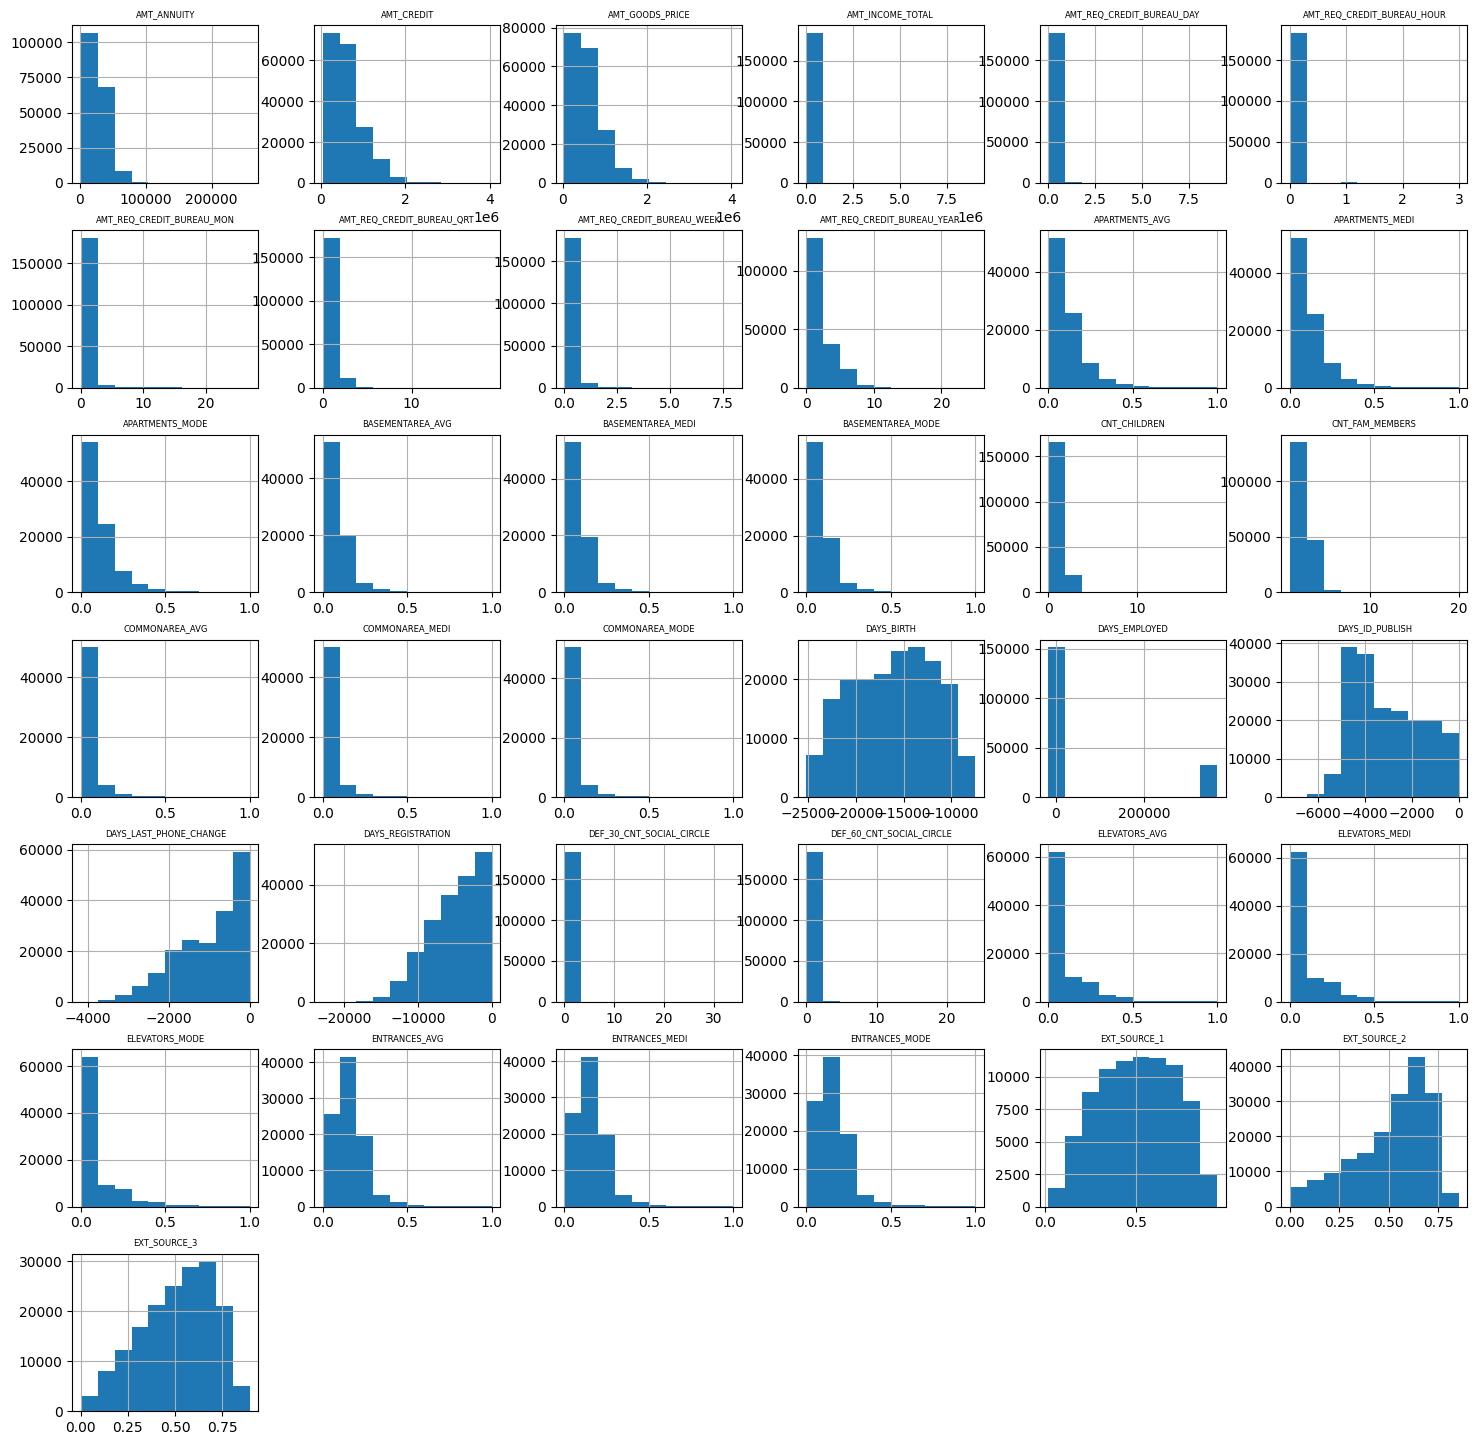

In [ ]:
# Gráficos de Dispersão ou Histogramas das variáveis
fig = plt.figure(figsize=(18, 18))
ax = fig.gca()
axes = df_app_train[colunas].hist(ax=ax)

# Ajusta o tamanho da fonte dos títulos
for ax in fig.axes:
    ax.set_title(ax.get_title(), fontsize=6
                 )

In [ ]:
df_app_train[colunas].describe()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
count,184342.000000,1.843500e+05,1.841850e+05,1.843500e+05,184350.000000,184350.000000,184350.000000,184350.000000,184350.000000,184350.000000,...,183776.000000,86941.000000,86941.000000,86941.000000,92435.000000,92435.000000,92435.000000,81891.000000,183971.000000,171508.000000
mean,27179.392578,6.067124e+05,5.454633e+05,1.711388e+05,0.006602,0.006417,0.268327,0.266037,0.034131,1.899550,...,0.099665,0.079292,0.078409,0.074799,0.150033,0.149510,0.145514,0.506871,0.517304,0.509984
std,14384.856445,4.048385e+05,3.714837e+05,1.026833e+05,0.106203,0.083877,0.916177,0.613603,0.203778,1.869815,...,0.362606,0.134922,0.134699,0.132492,0.100014,0.100323,0.100962,0.209691,0.189662,0.194284
min,1615.500000,4.500000e+04,4.050000e+04,2.610000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014568,0.000001,0.000527
25%,16587.000000,2.710665e+05,2.385000e+05,1.125000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.069000,0.069000,0.069000,0.340340,0.398428,0.370650
50%,24970.500000,5.212800e+05,4.500000e+05,1.575000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.137900,0.137900,0.137900,0.512329,0.568661,0.535276
75%,34780.500000,8.140410e+05,6.885000e+05,2.025000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.120000,0.120000,0.120800,0.206900,0.206900,0.206900,0.678773,0.665014,0.665855
max,258025.500000,4.050000e+06,4.050000e+06,9.000000e+06,9.000000,3.000000,27.000000,19.000000,8.000000,25.000000,...,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.951624,0.855000,0.896010


In [ ]:
# Calculando os inadimplentes da base
numerico = df_app_train['TARGET'].value_counts()
porcentagem = (df_app_train['TARGET'].value_counts(normalize=True) * 100).round(2)

tabela = pd.concat([numerico, porcentagem], axis=1)
tabela.columns = ['Quantidade', '%']

print(tabela)

        Quantidade      %
TARGET                   
0           170074  92.26
1            14276   7.74


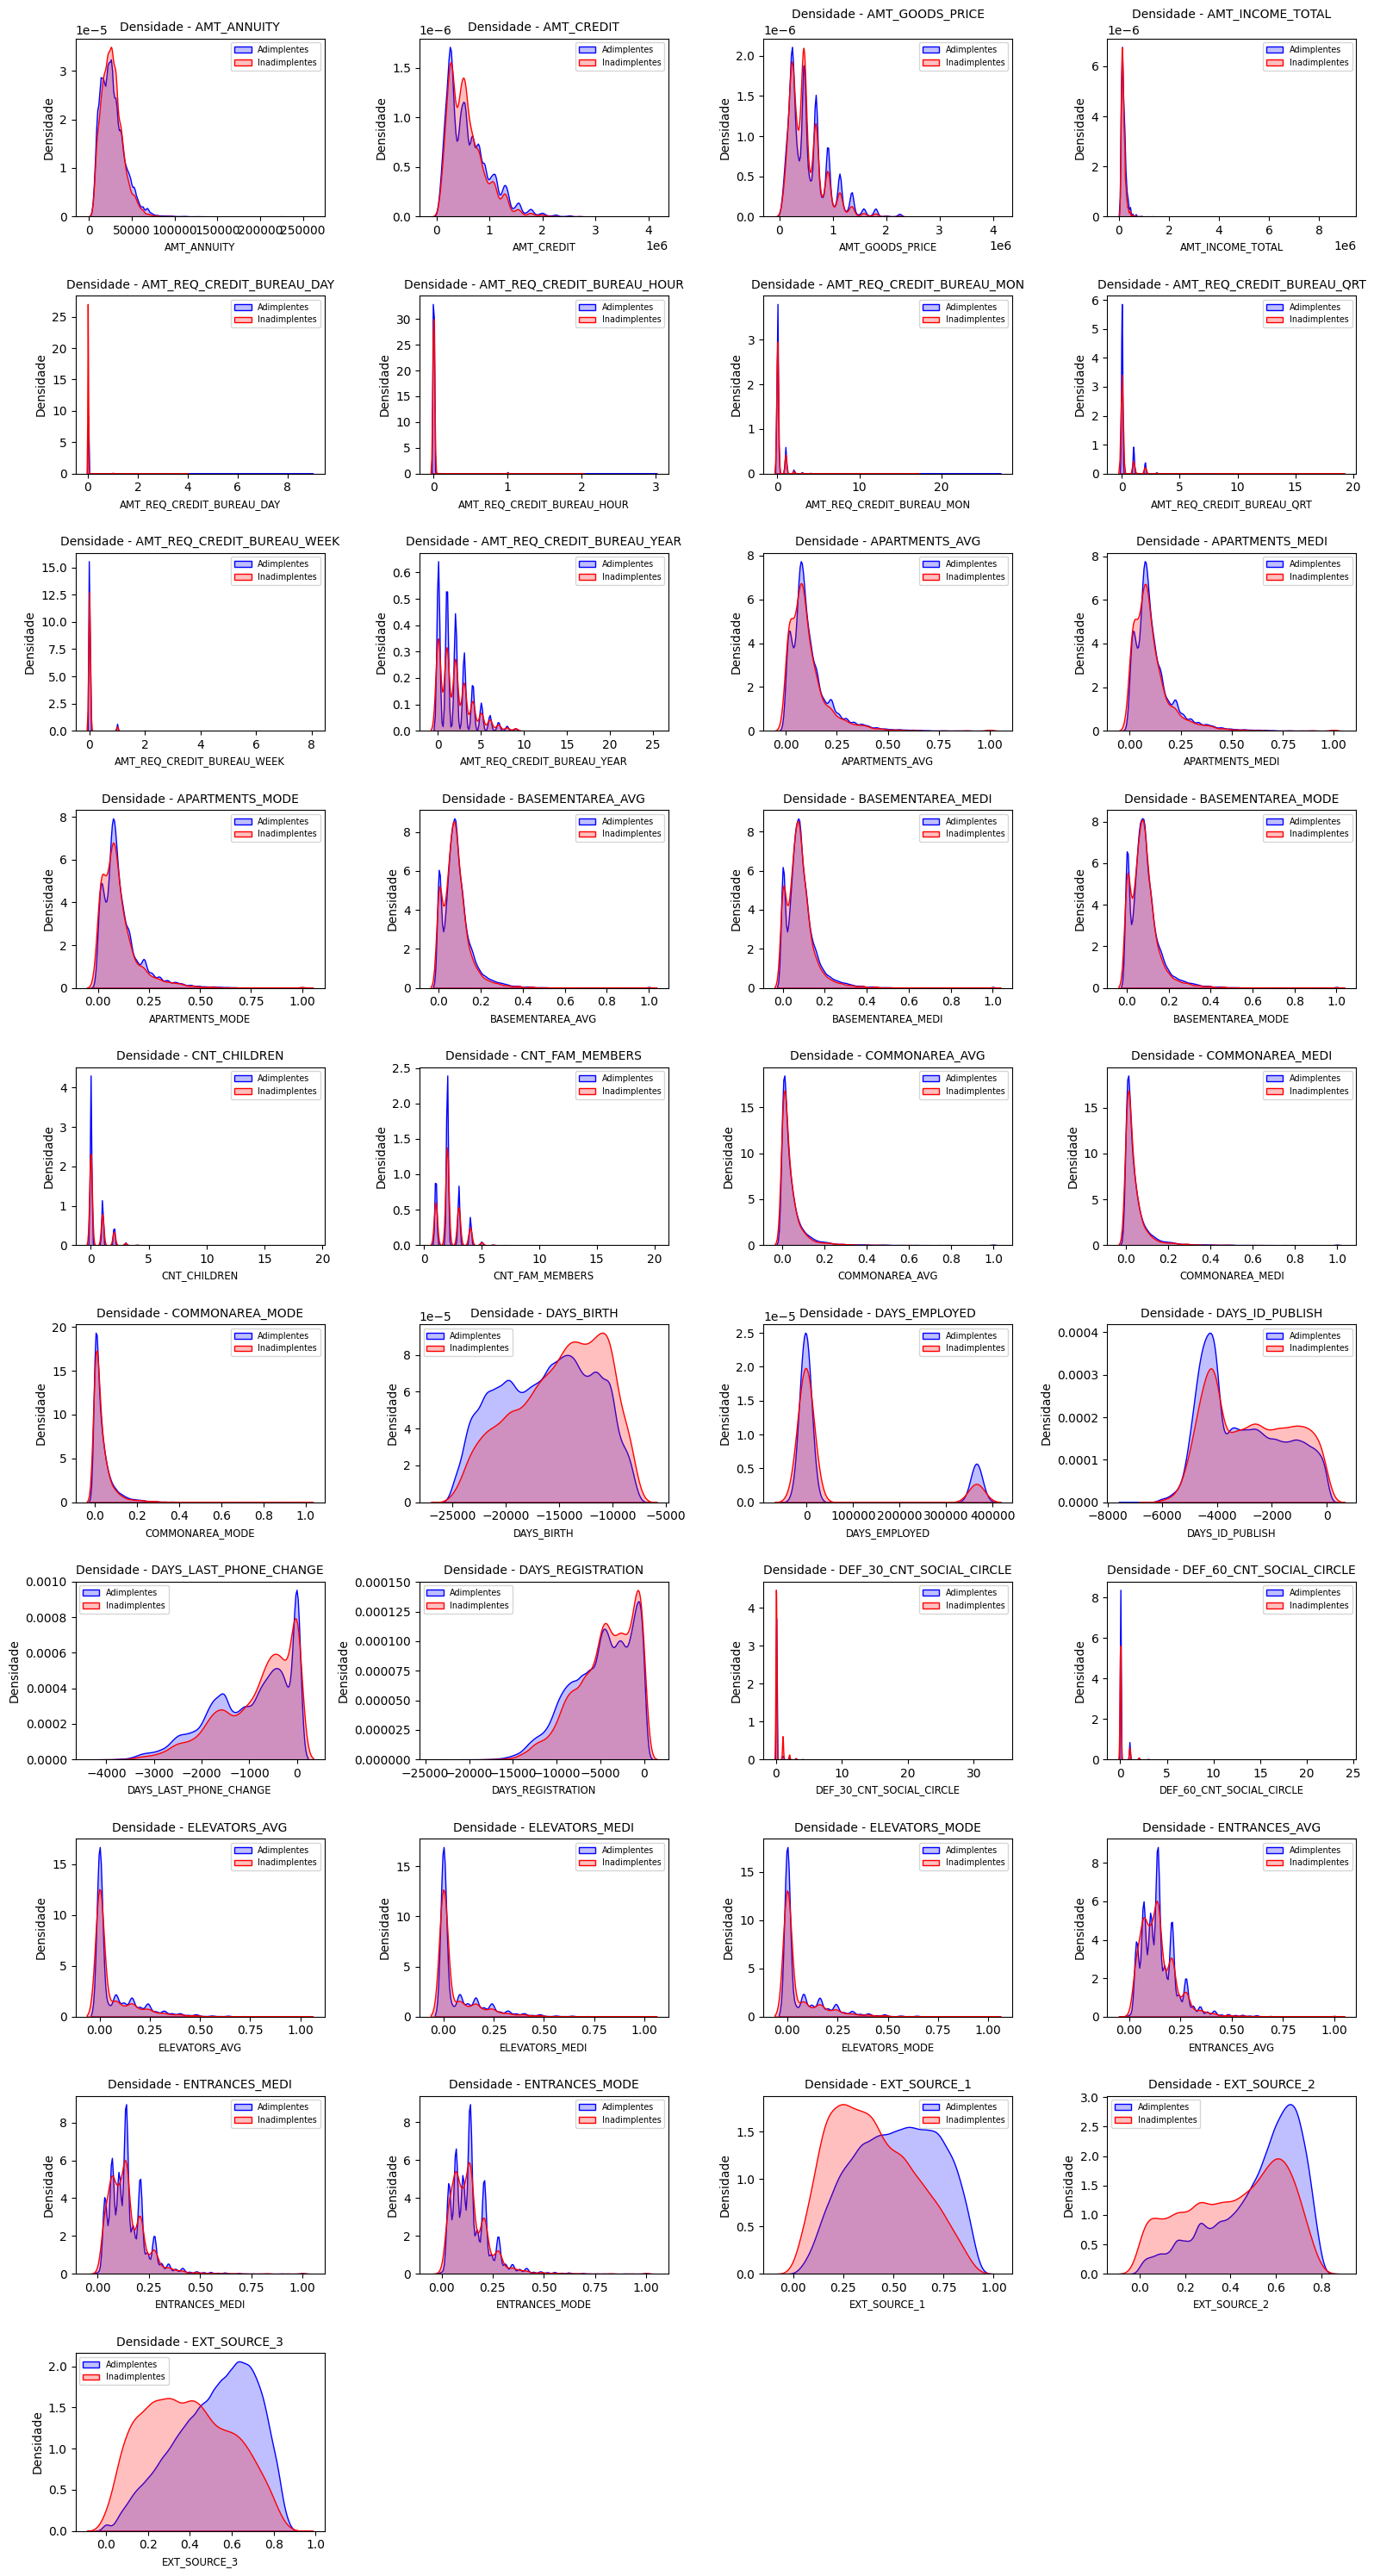

In [ ]:
import math

# Filtrar apenas colunas numéricas
variaveis_numericas = df_app_train[colunas].select_dtypes(include=['number']).columns

# Segmentar os dados
class_0 = df_app_train[df_app_train['TARGET'] == 0]
class_1 = df_app_train[df_app_train['TARGET'] == 1]

# Configuração da grade de gráficos
num_vars = len(variaveis_numericas)
ncols = 4
nrows = math.ceil(num_vars / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 3))
axes = axes.flatten()

# Plotagem
for i, col in enumerate(variaveis_numericas):
    ax = axes[i]
    try:
        sns.kdeplot(class_0[col].dropna(), fill=True, color='b', label='Adimplentes', ax=ax)
        sns.kdeplot(class_1[col].dropna(), fill=True, color='r', label='Inadimplentes', ax=ax)
        ax.set_xlabel(col, fontsize='small')
        ax.set_ylabel('Densidade')
        ax.legend(fontsize='x-small')
        ax.set_title(f'Densidade - {col}', fontsize=10)
    except Exception as e:
        ax.set_visible(False)  # Esconde o gráfico se houver erro

# Esconder eixos vazios restantes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Calculando a inadimplência por  tipo de Contrato: Cash loans (Empréstimo Pessoal) e Revolving loans (Empréstimo Rotativo)
numerico = df_app_train.groupby('NAME_CONTRACT_TYPE')['TARGET'].value_counts()
porcentagem = (df_app_train.groupby('NAME_CONTRACT_TYPE')['TARGET'].value_counts(normalize=True) * 100).round(2)

tabela = pd.concat([numerico, porcentagem], axis=1)
tabela.columns = ['Quantidade', '%']
print(tabela)

                           Quantidade      %
NAME_CONTRACT_TYPE TARGET                   
Cash loans         0           153539  91.99
                   1            13368   8.01
Revolving loans    0            16535  94.79
                   1              908   5.21


In [ ]:
# Valor Total de Renda
df_app_train['AMT_INCOME_TOTAL'].describe().round(2)

,AMT_INCOME_TOTAL
count,184350.00
mean,171138.77
std,102683.30
min,26100.00
25%,112500.00
50%,157500.00
75%,202500.00
max,9000000.00


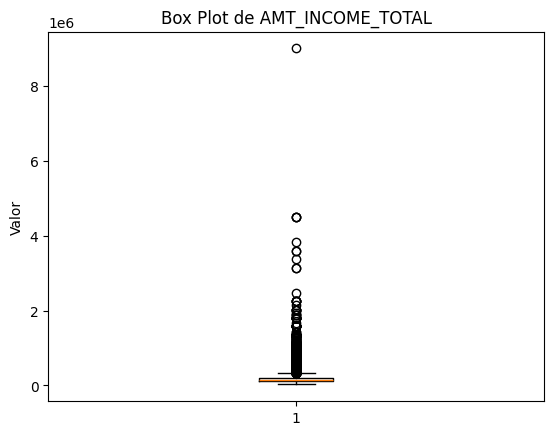

In [ ]:
# Box plot Valor Total de Renda
plt.boxplot(df_app_train['AMT_INCOME_TOTAL'])
plt.title('Box Plot de AMT_INCOME_TOTAL')
plt.ylabel('Valor')
plt.show()

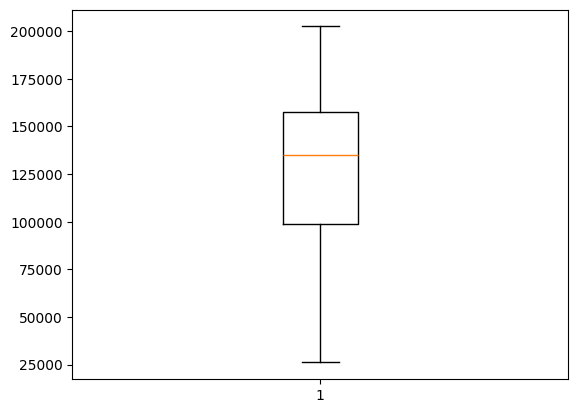

In [ ]:
# Retirando os outliers
# Calculando o valor do terceiro quartil (75%)
Q3 = df_app_train['AMT_INCOME_TOTAL'].quantile(0.75)

# Filtrando os valores acima do Q3
df_filtered = df_app_train[df_app_train['AMT_INCOME_TOTAL'] <= Q3]

plt.boxplot(df_filtered['AMT_INCOME_TOTAL'])
plt.show()

In [ ]:
df_filtered['AMT_INCOME_TOTAL'].describe().round(2)

,AMT_INCOME_TOTAL
count,139542.00
mean,130771.85
std,40782.89
min,26100.00
25%,99000.00
50%,135000.00
75%,157500.00
max,202500.00


In [ ]:
# Valor do Empréstimo  (Ticket médio por empréstimo (média))

df_app_train['AMT_CREDIT'].describe().round(2)

,AMT_CREDIT
count,184350.00
mean,606712.44
std,404838.53
min,45000.00
25%,271066.50
50%,521280.00
75%,814041.00
max,4050000.00


In [ ]:
# Criando a coluna idade

df_app_train['idade'] = (df_app_train['DAYS_BIRTH'] / -365).round(0)
df_app_train['idade'].describe().round(2)

,idade
count,184350.0
mean,44.1
std,11.81
min,21.0
25%,34.0
50%,43.0
75%,54.0
max,69.0


In [ ]:
colunas_cat = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS']

In [ ]:
df_app_train[colunas_cat].describe()

,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS
count,184350,184350,184350
unique,8,5,5
top,Working,Secondary / secondary special,Married
freq,95035,129706,119627


In [ ]:
95035/184350

0.5155139679956604

In [ ]:
129706/184350

0.7035855709248712

In [ ]:
df_app_train['CNT_FAM_MEMBERS'].describe()

,CNT_FAM_MEMBERS
count,184350.000000
mean,2.165441
std,0.909646
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,20.000000
